In [33]:
import os
import re
import ast

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from neurovlm.data import get_data_dir
from neurovlm.models import Specter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

## Computing latents

In [36]:
# # Load specter
# specter_neuro = Specter("allenai/specter2", adapter="Jerjes/neuro-specter2-multi-pool")
# specter_adhoc = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")

specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
proj_head = torch.load(f"proj_head_text_infonce.pt", weights_only=False, map_location="cpu")

There are adapters available but none are activated for the forward pass.


In [37]:
# Read data
neuro_structured = pd.read_csv('../../neuro_structured.csv')
neuro_judge = pd.read_csv('../../neuro_judge.csv')

In [38]:
def extract_markdown_sections(
    df: pd.DataFrame,
    text_col: str,
    sections=(
        "Networks",
        "Key Regions",
        "Cognitive Functions",
        "Clinical Relevance",
    ),
) -> pd.DataFrame:
    """
    Extracts Markdown sections (### Section Name) from a text column
    and returns a new DataFrame with additional columns per section.
    """

    def parse_text(text):
        if not isinstance(text, str):
            return {s: "" for s in sections}

        # Regex to capture ### Header followed by text until next ### or end
        pattern = r"###\s+(.*?)\n(.*?)(?=\n###|\Z)"
        matches = re.findall(pattern, text, flags=re.DOTALL)

        parsed = {s: "" for s in sections}
        for header, content in matches:
            header = header.strip()
            if header in parsed:
                parsed[header] = content.strip()

        return parsed

    extracted = df[text_col].apply(parse_text)
    extracted_df = pd.DataFrame(extracted.tolist(), index=df.index)

    return pd.concat([df.copy(), extracted_df], axis=1)


structured_summaries_df = extract_markdown_sections(neuro_structured, text_col="structured_summary")
braintotext_summaries_df = extract_markdown_sections(neuro_structured, text_col="brain_to_text_summary")

In [39]:
# --- helper ---
def embed_cell(x):
    if pd.isna(x) or x == "":
        return None
    
    with torch.no_grad():
        emb = specter(str(x))
        emb = emb / emb.norm()

        aligned_emb = proj_head.to("cpu")(emb)

    # Handle torch / numpy / list outputs safely
    if hasattr(aligned_emb, "detach"):        # torch.Tensor
        aligned_emb = aligned_emb.detach().cpu().numpy()

    aligned_emb = np.asarray(aligned_emb).squeeze()   # remove (1, D) → (D,)
    return aligned_emb.tolist()

# summaries
structured_summaries_latents_df = pd.DataFrame(
    index=structured_summaries_df.index
)

structured_summaries_latents_df["doi"] = structured_summaries_df["doi"]

for col in [
    "Networks",
    "Key Regions",
    "Cognitive Functions",
    "Clinical Relevance",
]:
    structured_summaries_latents_df[f"{col} latent"] = (
        structured_summaries_df[col].apply(embed_cell)
    )


In [40]:
# brain to text summaries
braintotext_summaries_latents_df = pd.DataFrame(
    index=braintotext_summaries_df.index
)   

braintotext_summaries_latents_df["doi"] = braintotext_summaries_df["doi"]

for col in [
    "Networks",
    "Key Regions",
    "Cognitive Functions",
    "Clinical Relevance",
]:
    braintotext_summaries_latents_df[f"{col} latent"] = (
        braintotext_summaries_df[col].apply(embed_cell)
    )


In [41]:
# Abstract and brain to text summary embeddings
abstract_btt_df = pd.DataFrame(
    index=braintotext_summaries_df.index
)   

abstract_btt_df["doi"] = braintotext_summaries_df["doi"]
for col in [
    "abstract",
    "brain_to_text_summary"
]:
    abstract_btt_df[f"{col} latent"] = (
        braintotext_summaries_df[col].apply(embed_cell)
    )

In [42]:
structured_summaries_latents_df.to_csv("structured_summaries_latents_proj.csv", index=False)
braintotext_summaries_latents_df.to_csv("braintotext_summaries_latents_proj.csv", index=False) 
abstract_btt_df.to_csv("abstract_btt_latents_proj.csv", index=False)

## Loading latents

In [47]:
structured_summaries_latents_df.head()

,doi,Networks latent,Key Regions latent,Cognitive Functions latent,Clinical Relevance latent
0,10.1523/JNEUROSCI.1358-12.2012,"[0.01836247369647026, 0.014406248927116394, 0....","[-0.017114844173192978, -0.022714756429195404,...","[-0.012375572696328163, -0.028720632195472717,...","[-0.022253740578889847, -0.04556147754192352, ..."
1,10.1073/pnas.2010890117,"[0.04304240643978119, -0.20246857404708862, -0...","[-0.010592583566904068, -0.22657203674316406, ...","[0.08279146254062653, -0.12424571067094803, 0....","[0.06405317038297653, -0.013385921716690063, 0..."
2,10.1038/s41467-019-12937-5,"[0.009493622928857803, -0.12528619170188904, 0...","[0.0954955592751503, -0.11181610822677612, 0.1...","[0.026245664805173874, -0.09972142428159714, 0...","[0.08748114109039307, -0.02772766351699829, 0...."
3,10.1016/j.neuroimage.2020.116922,"[0.004963984712958336, -0.0960351973772049, -0...","[0.021813690662384033, -0.06635935604572296, -...","[0.014576632529497147, -0.0627727210521698, -0...","[0.041249316185712814, -0.013032063841819763, ..."
4,10.1523/ENEURO.0222-17.2018,"[-0.011613525450229645, 0.019507497549057007, ...","[-0.05007956549525261, -0.0010060817003250122,...","[-0.027391323819756508, -0.022609204053878784,...","[-0.021148378029465675, -0.05304521322250366, ..."


In [43]:
structured_summaries_latents_df = pd.read_csv("structured_summaries_latents_proj.csv")
braintotext_summaries_latents_df = pd.read_csv("braintotext_summaries_latents_proj.csv")
abstract_btt_df = pd.read_csv("abstract_btt_latents_proj.csv")

## Old bar plot fig

In [ ]:
# def recall_at_k_random(
#     col_a,
#     col_b,
#     ks=(10, 20, 50, 100, 150, 200),
#     expected_dim=768,
# ):
#     def parse_embedding(x):
#         if x is None:
#             return None
#         if isinstance(x, str):
#             x = ast.literal_eval(x)
#         arr = np.asarray(x, dtype=np.float32)

#         # reject scalars or wrong shapes
#         if arr.ndim != 1: #or arr.shape[0] != expected_dim:
#             return None

#         return arr

#     # --- parse + filter jointly ---
#     A_list = []
#     B_list = []

#     for a, b in zip(col_a, col_b):
#         a_emb = parse_embedding(a)
#         b_emb = parse_embedding(b)

#         if a_emb is None or b_emb is None:
#             continue

#         A_list.append(a_emb)
#         B_list.append(b_emb)

#     if len(A_list) == 0:
#         raise ValueError("No valid embedding pairs found.")

#     A = np.vstack(A_list)
#     B = np.vstack(B_list)

#     # --- L2 normalize ---
#     A = normalize(A, norm="l2", axis=1)
#     B = normalize(B, norm="l2", axis=1)

#     print(f"Using {A.shape[0]} valid pairs")

#     # --- cosine similarity ---
#     sim_matrix = cosine_similarity(A, B)

#     # --- recall@k ---
#     N = sim_matrix.shape[0]
#     ranked_indices = np.argsort(-sim_matrix, axis=1)

#     recalls = {}
#     for k in ks:
#         recalls[k] = np.mean(
#             [i in ranked_indices[i, :k] for i in range(N)]
#         )

#     for k, v in recalls.items():
#         print(f"Recall@{k}: {v:.3f}")

#     return recalls


In [ ]:
# """
# If we prefer comparing the actual abstract against individial sections
# """
# recall_abstract_btt = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=abstract_btt_df["brain_to_text_summary latent"])
# recall_networks = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Networks latent"])
# recall_key_regions = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Key Regions latent"])
# recall_cog_funcs = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Cognitive Functions latent"])
# recall_clinical_relevance = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Clinical Relevance latent"])

In [ ]:
# """
# If we prefer comparing the LLM parsed sections of the abstracts against the generated sections
# """
# recall_abstract_btt = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=abstract_btt_df["brain_to_text_summary latent"])
# recall_networks = recall_at_k_random(col_a=structured_summaries_latents_df["Networks latent"], col_b=braintotext_summaries_latents_df["Networks latent"])
# recall_key_regions = recall_at_k_random(col_a=structured_summaries_latents_df["Key Regions latent"], col_b=braintotext_summaries_latents_df["Key Regions latent"])
# recall_cog_funcs = recall_at_k_random(col_a=structured_summaries_latents_df["Cognitive Functions latent"], col_b=braintotext_summaries_latents_df["Cognitive Functions latent"])
# recall_clinical_relevance = recall_at_k_random(col_a=structured_summaries_latents_df["Clinical Relevance latent"], col_b=braintotext_summaries_latents_df["Clinical Relevance latent"])

In [ ]:
# # --- data ---
# recalls = {
#     "Abstract → Brain-to-Text": recall_abstract_btt,
#     "Networks": recall_networks,
#     "Key Regions": recall_key_regions,
#     "Cognitive Functions": recall_cog_funcs,
#     "Clinical Relevance": recall_clinical_relevance,
# }

# ks = sorted(recall_abstract_btt.keys())
# x = np.arange(len(ks))

# # --- figure layout ---
# fig = plt.figure(figsize=(14, 6))
# gs = fig.add_gridspec(2, 3, width_ratios=[2.2, 1, 1], wspace=0.35, hspace=0.4)

# # --- left: main plot ---
# ax_main = fig.add_subplot(gs[:, 0])
# ax_main.bar(x, [recalls["Abstract → Brain-to-Text"][k] for k in ks])
# ax_main.set_xticks(x)
# ax_main.set_xticklabels([f"R@{k}" for k in ks])
# ax_main.set_ylim(0, 1.0)
# ax_main.set_ylabel("Recall")
# ax_main.set_title("Abstract → Brain-to-Text Retrieval", fontsize=14, weight="bold")

# # annotate values
# for i, k in enumerate(ks):
#     v = recalls["Abstract → Brain-to-Text"][k]
#     ax_main.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# # --- right: 4 smaller plots ---
# titles = [
#     "Networks",
#     "Key Regions",
#     "Cognitive Functions",
#     "Clinical Relevance",
# ]

# axes = [
#     fig.add_subplot(gs[0, 1]),
#     fig.add_subplot(gs[0, 2]),
#     fig.add_subplot(gs[1, 1]),
#     fig.add_subplot(gs[1, 2]),
# ]

# for ax, title in zip(axes, titles):
#     vals = [recalls[title][k] for k in ks]
#     ax.bar(x, vals)
#     ax.set_xticks(x)
#     ax.set_xticklabels([f"R@{k}" for k in ks], fontsize=6)
#     ax.set_ylim(0, 1.0)
#     ax.set_title(title, fontsize=11)

#     for i, v in enumerate(vals):
#         ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

# # --- overall title ---
# # fig.suptitle("Cross-Modal Retrieval Recall@K", fontsize=16, y=1.02)

# plt.show()


## New curve plot

In [ ]:
def recall_curve_from_embeddings(
    col_a,
    col_b,
    ks=(10, 20, 50, 100, 150, 200),
):
    def parse_embedding(x):
        if x is None:
            return None
        if isinstance(x, str):
            x = ast.literal_eval(x)
        arr = np.asarray(x, dtype=np.float32)

        if arr.ndim != 1:
            return None
        return arr

    # --- parse + filter jointly ---
    A_list, B_list = [], []

    for a, b in zip(col_a, col_b):
        a_emb = parse_embedding(a)
        b_emb = parse_embedding(b)

        if a_emb is None or b_emb is None:
            continue

        A_list.append(a_emb)
        B_list.append(b_emb)

    if len(A_list) == 0:
        raise ValueError("No valid embedding pairs found.")

    A = np.vstack(A_list)
    B = np.vstack(B_list)

    # --- normalize ---
    A = normalize(A, axis=1)
    B = normalize(B, axis=1)

    N = A.shape[0]
    print(f"Using {N} valid pairs (dim={A.shape[1]})")

    # --- cosine similarity ---
    sim_matrix = cosine_similarity(A, B)

    # --- rank of true match for each query ---
    ranked = np.argsort(-sim_matrix, axis=1)

    true_ranks = np.array([
        np.where(ranked[i] == i)[0][0] + 1  # 1-based
        for i in range(N)
    ])

    # --- full recall curve ---
    recall_curve = np.array([
        np.mean(true_ranks <= k)
        for k in range(1, N + 1)
    ])

    k_norm = np.arange(1, N + 1) / N

    # --- Recall@K summary ---
    recall_at_k = {
        k: np.mean(true_ranks <= k)
        for k in ks
        if k <= N
    }

    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.3f}")

    return {
        "k_norm": k_norm,
        "recall": recall_curve,
        "recall_at_k": recall_at_k,
        "N": N,
    }


In [58]:
curve_abstract_btt = recall_curve_from_embeddings(
    col_a=abstract_btt_df["abstract latent"],
    col_b=abstract_btt_df["brain_to_text_summary latent"],
)

curve_networks = recall_curve_from_embeddings(
    col_a=abstract_btt_df["abstract latent"],
    col_b=braintotext_summaries_latents_df["Networks latent"],
)

curve_key_regions = recall_curve_from_embeddings(
    col_a=abstract_btt_df["abstract latent"],
    col_b=braintotext_summaries_latents_df["Key Regions latent"],
)

curve_cog_funcs = recall_curve_from_embeddings(
    col_a=abstract_btt_df["abstract latent"],
    col_b=braintotext_summaries_latents_df["Cognitive Functions latent"],
)

curve_clinical_relevance = recall_curve_from_embeddings(
    col_a=abstract_btt_df["abstract latent"],
    col_b=braintotext_summaries_latents_df["Clinical Relevance latent"],
)


Using 312 valid pairs (dim=384)
Recall@10: 0.125
Recall@20: 0.202
Recall@50: 0.356
Recall@100: 0.548
Recall@150: 0.708
Recall@200: 0.833
Using 312 valid pairs (dim=384)
Recall@10: 0.106
Recall@20: 0.163
Recall@50: 0.304
Recall@100: 0.494
Recall@150: 0.679
Recall@200: 0.811
Using 312 valid pairs (dim=384)
Recall@10: 0.125
Recall@20: 0.186
Recall@50: 0.314
Recall@100: 0.506
Recall@150: 0.670
Recall@200: 0.824
Using 312 valid pairs (dim=384)
Recall@10: 0.087
Recall@20: 0.157
Recall@50: 0.349
Recall@100: 0.538
Recall@150: 0.689
Recall@200: 0.798
Using 312 valid pairs (dim=384)
Recall@10: 0.131
Recall@20: 0.186
Recall@50: 0.349
Recall@100: 0.538
Recall@150: 0.721
Recall@200: 0.795


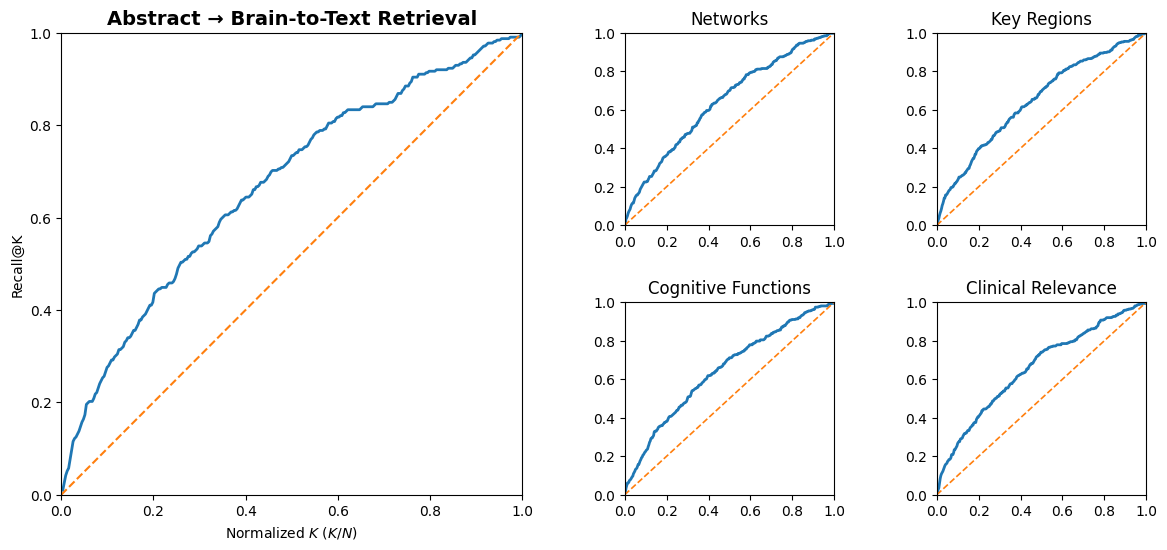

In [ ]:
# --- data ---
curves = {
    "Abstract → Brain-to-Text": curve_abstract_btt,
    "Networks": curve_networks,
    "Key Regions": curve_key_regions,
    "Cognitive Functions": curve_cog_funcs,
    "Clinical Relevance": curve_clinical_relevance,
}

# --- figure layout ---
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(
    2, 3,
    width_ratios=[2.2, 1, 1],
    wspace=0.35,
    hspace=0.4,
)

# --- left: main curve ---
ax_main = fig.add_subplot(gs[:, 0])

x = curves["Abstract → Brain-to-Text"]["k_norm"]
y = curves["Abstract → Brain-to-Text"]["recall"]

ax_main.plot(x, y, linewidth=2)
ax_main.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5)  # chance

ax_main.set_xlim(0, 1)
ax_main.set_ylim(0, 1)
ax_main.set_xlabel(r"Normalized $K$ ($K / N$)")
ax_main.set_ylabel("Recall@K")
ax_main.set_title(
    "Abstract → Brain-to-Text Retrieval",
    fontsize=14,
    weight="bold",
)

# --- right: 4 smaller curves ---
titles = [
    "Networks",
    "Key Regions",
    "Cognitive Functions",
    "Clinical Relevance",
]

axes = [
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
]

for ax, title in zip(axes, titles):
    x = curves[title]["k_norm"]
    y = curves[title]["recall"]

    ax.plot(x, y, linewidth=2)
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)  # chance

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis="both", labelsize=10)

# --- overall title (optional) ---
# fig.suptitle("Cross-Modal Retrieval Recall Curves", fontsize=16, y=1.02)

plt.show()


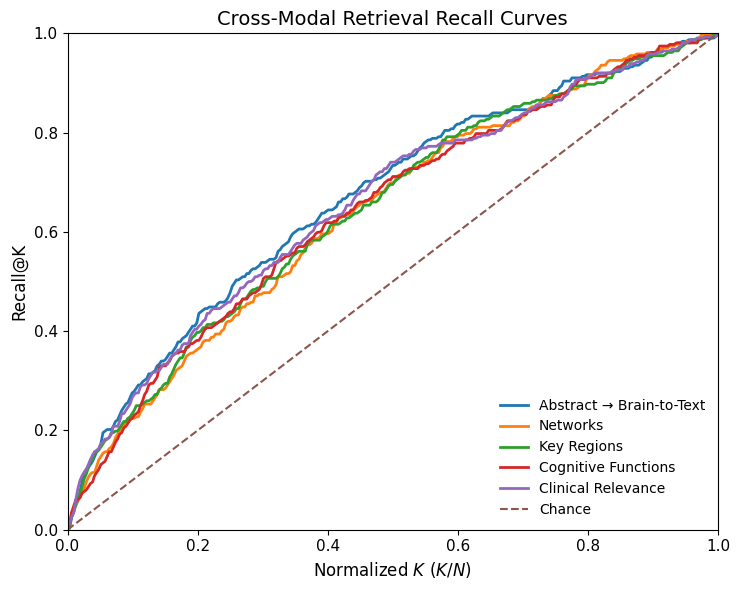

In [ ]:
# --- collect curves ---
curves = {
    "Abstract → Brain-to-Text": curve_abstract_btt,
    "Networks": curve_networks,
    "Key Regions": curve_key_regions,
    "Cognitive Functions": curve_cog_funcs,
    "Clinical Relevance": curve_clinical_relevance,
}

# --- figure ---
fig, ax = plt.subplots(figsize=(7.5, 6))

# plot each recall curve
for label, curve in curves.items():
    ax.plot(
        curve["k_norm"],
        curve["recall"],
        linewidth=2,
        label=label,
    )

# chance baseline
ax.plot(
    [0, 1], [0, 1],
    linestyle="--",
    linewidth=1.5,
    label="Chance",
)

# axes + labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r"Normalized $K$ ($K / N$)", fontsize=12)
ax.set_ylabel("Recall@K", fontsize=12)
ax.set_title("Cross-Modal Retrieval Recall Curves", fontsize=14)

# legend
ax.legend(
    frameon=False,
    fontsize=10,
    loc="lower right",
)

ax.tick_params(axis="both", labelsize=11)

plt.tight_layout()
plt.show()


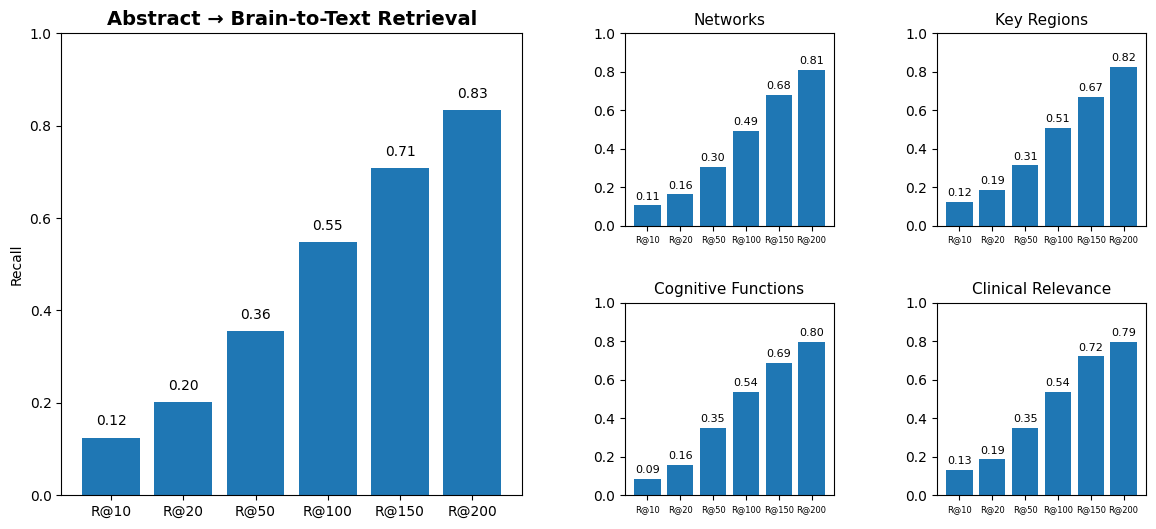

In [55]:
import numpy as np

def recall_curve_from_sim(sim_matrix):
    """
    sim_matrix: (N, N), higher = more similar
    Returns:
        ks_norm: array of K/N
        recall:  array of Recall@K
    """
    N = sim_matrix.shape[0]

    # rank indices for each query
    ranked = np.argsort(-sim_matrix, axis=1)

    # rank position of the true match for each query
    true_ranks = np.array([
        np.where(ranked[i] == i)[0][0] + 1
        for i in range(N)
    ])  # 1-based ranks

    recall = np.zeros(N)
    for k in range(1, N + 1):
        recall[k - 1] = np.mean(true_ranks <= k)

    ks_norm = np.arange(1, N + 1) / N
    return ks_norm, recall


In [ ]:
curves = {
    "Abstract → Brain-to-Text": recall_curve_from_sim(sim_abstract_btt),
    "Networks": recall_curve_from_sim(sim_networks),
    "Key Regions": recall_curve_from_sim(sim_key_regions),
    "Cognitive Functions": recall_curve_from_sim(sim_cog_funcs),
    "Clinical Relevance": recall_curve_from_sim(sim_clinical_relevance),
}
